# Preprocess data and apply time series ML


In [1]:
%reload_ext autoreload
# for auto reloading modules without kernel restart
# If this does not work to import custom modules, then restart kernel

In [2]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_21380\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [4]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Load processed time series static-dynamic-static cycle samples with cell IDs
It is a list of valid charge/discharge/dynamic cycles with static voltage in the beginning and end

In [7]:
# Save list as pkl checkpoint
import pickle
    
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'cell_cycles.pkl')

with open(src_path, 'rb') as f:
    li_ts_cycles = pickle.load(f)

In [8]:
import math

# print(li_ts_cycles)
# Separate training, validation and test cycles, keep cycles without cell ID
TRAIN_SAMPLES = 0.7
li_train_cycles = []      # each of this list is a separate static_dynamic_static cycle
li_validation_cycles = []
li_test_cycles= []

total_cycles = 0
for (cell, li_cycles) in li_ts_cycles:              # each cell contain multiple cycles
    num_cell_cycles = len(li_cycles)
    num_train_cycles = math.ceil(num_cell_cycles * TRAIN_SAMPLES)                 # training cycle samples 70%
    num_validation_cycles = math.ceil((num_cell_cycles - num_train_cycles) * 0.5)
    num_test_cycles = num_cell_cycles - num_validation_cycles - num_train_cycles
    total_cycles += len(li_cycles)
    # print(num_cell_cycles, num_train_cycles, num_validation_cycles, num_test_cycles)

    li_train_cycles += li_cycles[0:num_train_cycles]
    li_validation_cycles += li_cycles[num_train_cycles:num_train_cycles+num_validation_cycles]
    li_test_cycles += li_cycles[num_train_cycles+num_validation_cycles:]

print(total_cycles, len(li_train_cycles), len(li_validation_cycles), len(li_test_cycles))     # test
# print(li_train_cycles[2])

626 515 101 10


In [13]:
df_1 = li_train_cycles[0].head(10)
# display(df_1)
print(df_1.to_latex(index=False))  

\begin{tabular}{lrrrrrrrr}
\toprule
          timestamp &  current &  min\_SOC &  cur\_integral\_module1 &  contactor\_state &  contactor\_off\_time &      V &  Temp &  elapsed\_sec \\
\midrule
2022-01-18 13:02:17 &      0.0 &    99.70 &                   0.0 &              0.0 &              1864.0 & 4.1430 &  12.0 &          0.0 \\
2022-01-18 13:02:18 &      0.0 &    99.70 &                   0.0 &              0.0 &              1864.0 & 4.1400 &  13.0 &          1.0 \\
2022-01-18 13:02:19 &      0.0 &    99.87 &                   0.0 &              0.0 &             10522.0 & 4.1400 &  13.0 &          2.0 \\
2022-01-18 13:02:20 &      0.0 &    99.87 &                   0.0 &              0.0 &             10523.0 & 4.1400 &  13.0 &          3.0 \\
2022-01-18 13:02:21 &      0.0 &    99.86 &                   0.0 &              0.0 &             10524.0 & 4.1400 &  13.0 &          4.0 \\
2022-01-18 13:02:22 &      0.0 &    99.87 &                   0.0 &              0.0 &          

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_21380\2138981221.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_1.to_latex(index=False))


<IPython.core.display.Javascript object>


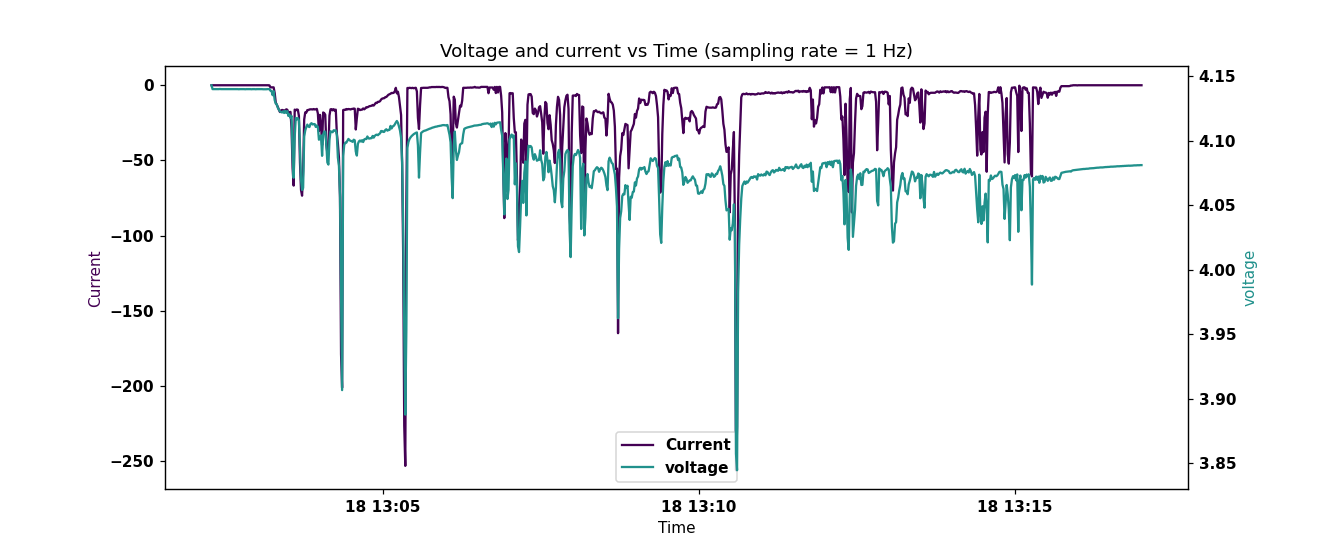

In [35]:
%matplotlib notebook

fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'volt_follows_cur.pdf')

for df_each in li_train_cycles:
    df_temp = df_each.copy()
    custom_plot.plot_dual_axis_new(("Voltage and current vs Time (sampling rate = 1 Hz)", plot_path), (df_temp['timestamp'], "Time"), (df_temp['current'], "Current"), (df_temp['V'], "voltage"))
    df_temp = np.nan
    break

In [34]:
# check index of each cycle dataframe
print(li_train_cycles[0].index)

Int64Index([1096325, 1096326,  965787,  965788,  965789,  965790, 1096331,
             965792,  965793,  965794,
            ...
            1097199, 1097200, 1097201,  966662,  966663,  966664,  966665,
            1097206, 1097207, 1097208],
           dtype='int64', length=884)


### Concat all the valid cycles and add a elapsed_second column for an easy timestamp (test)

True
1738245


<IPython.core.display.Javascript object>


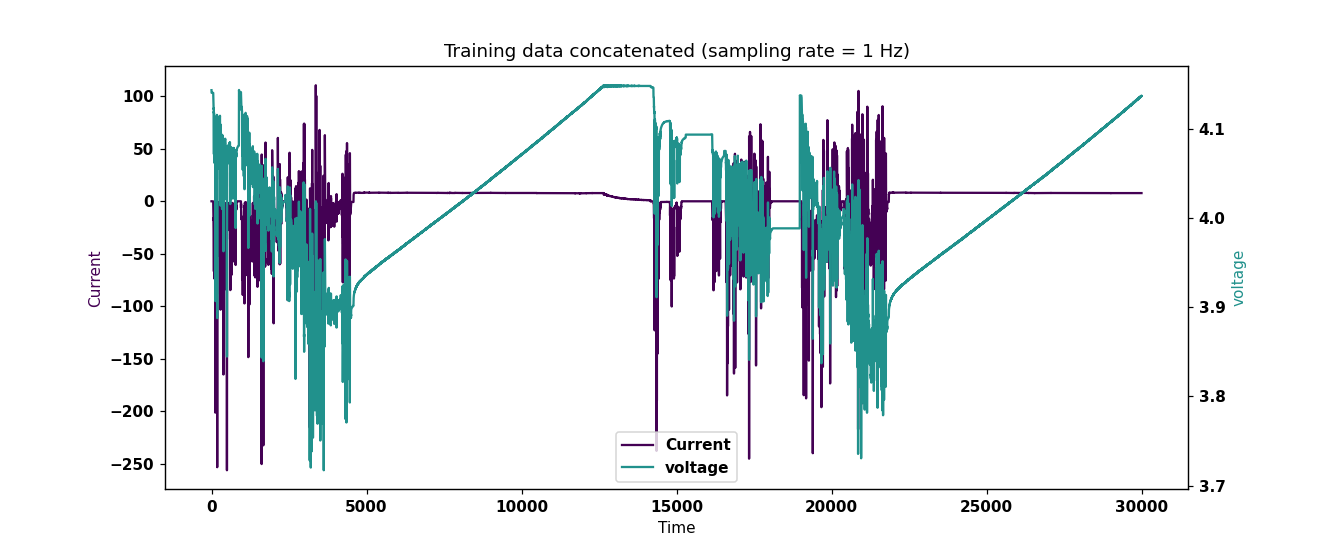

In [63]:
df_train_cycles = pd.concat(li_train_cycles)
df_val_cycles = pd.concat(li_validation_cycles)
df_test_cycles = pd.concat(li_test_cycles)

df_train_cycles.reset_index(drop=True, inplace=True)
df_val_cycles.reset_index(drop=True, inplace=True)
df_test_cycles.reset_index(drop=True, inplace=True)

fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'concat_train.pdf')

print(df_train_cycles.index.is_monotonic_increasing)   # check if monotonically increasing index
print(len(df_train_cycles))  # 1.59 million individual data points

plot_samples = 30000
df_temp = df_train_cycles.head(plot_samples)

custom_plot.plot_dual_axis_new(("Training data concatenated (sampling rate = 1 Hz)", plot_path), (df_temp.index, "Time"), (df_temp['current'], "Current"), (df_temp['V'], "voltage"))

### Show corelation between current and voltage
1. The correlation throws absolutely no light on questions of process or causation. It's just a descriptive measure of strength of linear association.
2. Correlation coefficient means how much two series vary together
3. Corrleation 1 means two series strongly vary together, have perfect linear relationship with no deviation
4. High correlation means 2 series strongly vary together
5. Low correlation menas they vary together but weak association
6. 

<IPython.core.display.Javascript object>


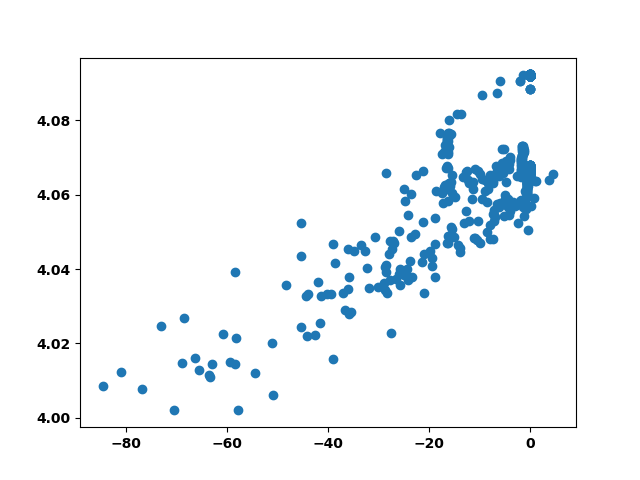

Pearsons correlation: 0.819


In [89]:



%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# plot_samples = 30000
, li_cycles = li_ts_cycles[0]
df_temp = li_cycles[4]

# sns.regplot(x=df_temp["current"], y=df_temp["V"])
# corr = df_temp[['current', 'V']].corr()
# print(corr)
df_cor = pd.DataFrame()
df_cor['cur_pct'] = df_temp['current'].pct_change()
df_cor['v_pct'] = df_temp['V'].pct_change()

# plt.scatter(df_cor['cur_pct'], df_cor['v_pct'])
plt.scatter(df_temp['current'], df_temp['V'])

# plt.xcorr(df_temp['current'], df_temp['V'], usevlines=True, maxlags=10, normed=True, lw=2)
# plt.grid(True)
# plt.axhline(0.2, color='blue', linestyle='dashed', lw=2)
# plt.ylim([0, 0.3])
# plt.title("Cross-correlation")
plt.show()


# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, _ = pearsonr(df_temp['current'], df_temp['V'])
print('Pearsons correlation: %.3f' % corr)


In [ ]:
%matplotlib notebook

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

, li_cycles = li_ts_cycles[0]
df_temp = li_cycles[4]

fft = tf.signal.rfft(df_temp['V'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_temp['V'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [71]:
# Make dataset ready for LSTM
# [temporal input sequence] [output]
# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_univariate(df_feature, df_label, window_size=5):
    df_feature_as_np = df_feature.to_numpy()
    df_label_as_np = df_label.to_numpy()
    X = []
    y = []
    for i in range(len(df_feature_as_np) - window_size):
        row = [[a] for a in df_feature_as_np[i:i+window_size]]
        X.append(row)
        label = df_label_as_np[i+window_size]
        y.append(label)
        print(X)
        print(y)
        break
    return np.array(X), np.array(y)



X1, y1 = df_to_supervised_univariate(df_train_cycles['current'], df_train_cycles['V'], WINDOW_SIZE)
X1.shape, y1.shape

[[[0.0], [0.0], [0.0]]]
[4.14]


((1, 3, 1), (1,))

### Univariate: use only current for LSTM model
1. An LSTM layer requires a three-dimensional input (#data_points, input time_steps, #variables)
2. LSTMs by default will produce a two-dimensional output  as an interpretation from the end of the sequence.
3. Consider running example a few times and compare the average outcome.

## Types of time series prediction
### A. Multiple input time series (mutlivariate time series)
1. Multiple variables over same TS, but prediction happens for one varaible
2. Example: Time series inputs: V, I, T 
   Output/prediction has to be made on V
4. Rephrase: how V changes with time wrt temporal values of V, I, T 

### B. Multiple parallel time series
1. There are several time series, each for separate variable
2. All the time series have same #time_steps
3. Data can be prepared in a way so that LSTM trains parallelly on each time series and predits on each variable (each column)
4. What if the parallel time serieses have different length i.e. variable total #time_steps?

### C. Multiple input-multiple parallel time series: multivariate and multiple parallel TS (A and B together)
1. Multiple time series samples, each TS being multivariate (this is the scenario)

In [ ]:
# Hyperparameters
# constant hyperparams: Train data: 60%, Val data: 20%, test data: 20%
EPOCHS = 10
# batch = 64
LR = 0.0001
adam = optimizers.Nadam() #(lr)
LSTM_neurons = 64

In [24]:
# not hyperparams
verbose = 2       # will just mention the number of epoch like this epoch 1/10, 2/10 etc. while training

In [16]:
df_current = df_connected_V1[current]
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df_votages, WINDOW_SIZE)
X1.shape, y1.shape

((49618, 5, 1), (49618,))

In [64]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train_cycles, val_df=df_val_cycles, test_df=df_test_cycles,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [65]:
# import tensorflow related libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [81]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# hyperparams
WINDOW_SIZE = 3
WIN_SIZE_INC = 3
EPOCHS = 10
NEURONS = 64

# date-time parsing function for loading the dataset
# def parser(x):
#     return datetime.strptime('190'+x, '%Y-%m')

# Make dataset ready for LSTM
# [temporal input sequence: current sequences] [output: voltage(s)]
# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_univariate(df_feature, df_label, window_size=5):
    df_feature_as_np = df_feature.to_numpy()
    df_label_as_np = df_label.to_numpy()
    X = []
    y = []
    for i in range(len(df_feature_as_np) - window_size):
        row = [[a] for a in df_feature_as_np[i:i+window_size]]
        X.append(row)
        label = df_label_as_np[i+window_size]
        y.append(label)
        print(X)
        print(y)
        break
    return np.array(X), np.array(y)

# create a differenced series
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return Series(diff)

# invert differenced value
# def inverse_difference(history, yhat, interval=1):
#     return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(df_train, df_val, df_test, type):       # type is the type of scaling, eg standard, normal etc.
    scaler_train = StandardScaler().fit(df_train)    # just fit, not transform yet
    train_scaled = scaler_train.transform(df_train)

    scaler_val = StandardScaler().fit(df_val)
    val_scaled = scaler_val.transform(df_val)
    
#     scaler_test = StandardScaler().fit(df_test)
#     test_scaled = scaler_test.transform(scaler_test)

    return train_scaled, val_scaled, df_test

# fit scaler
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler = scaler.fit(train)
    # transform train
#     train = train.reshape(train.shape[0], train.shape[1])
#     train_scaled = scaler.transform(train)
    # transform test
#     test = test.reshape(test.shape[0], test.shape[1])
#     test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train_X, train_y, val_X, val_y, batch_size, nb_epoch, neurons, window_size):
    model = Sequential()
    model.add(InputLayer((window_size, 1)))   # each of training input are a WINDOW_SIZE * 1 vector
    model.add(LSTM(neurons))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()
    
    # model
    cp1 = ModelCheckpoint('models/', save_best_only=True)         # save_best_only=true saves the best model with lowest validation loss
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=[cp1])
    
    # load model with lowest validation loss
    model = load_model('models/')
    
#     model = Sequential()
#     model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
#     model.add(Dense(8), 'relu')
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     for i in range(nb_epoch):
#         model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
#         model.reset_states()
#     return model



# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats):
    # transform data to be stationary
#     raw_values = series.values
#     diff_values = difference(raw_values, 1)

    # run experiment
    error_scores = list()
    for r in range(repeats):

        # only keep the features (current) and labels (voltage) for scaling
        df_train = df_train_cycles[['current', 'V']]
        df_val = df_val_cycles[['current', 'V']]
        df_test = df_test_cycles[['current', 'V']]

        # Scale
        df_scaled_train, df_scaled_val, df_scaled_test = scale(df_train, df_val, df_test, 0)
        
        # convert to sequences and labels
        train_X, train_y = df_to_supervised_univariate(df_scaled_train['current'], df_scaled_train['V'], WINDOW_SIZE)
        val_X, val_y = df_to_supervised_univariate(df_scaled_val['current'], df_scaled_val['V'], WINDOW_SIZE)
        test_X, test_y = df_to_supervised_univariate(df_scaled_test['current'], df_scaled_test['V'], WINDOW_SIZE)

        # fit the base model
        lstm_model = fit_lstm(train_X, train_y, val_X, val_y, 1, EPOCHS, NEURONS, WINDOW_SIZE)

        WINDOW_SIZE += WIN_SIZE_INC    # window size increase
        # forecast test dataset
        predictions = list()

        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)

    return error_scores

# execute the experiment
def run():
#     # load dataset
#     series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 5
    results = DataFrame()
    # run experiment
    timesteps = 1
    results['results'] = experiment(repeats)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_timesteps_1.csv', index=False)

 # entry point
run()

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_25572\1044601489.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [56]:
# split dataset into train, tesTypeError: float() argument must be a string or a number, not 'StandardScaler'
t, validationTypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

X_train1, y_train1 = X1[:38000], y1[:38000]
X_val1, y_val1 = X1[38000:44000], y1[38000:44000]
X_test1, y_test1 = X1[44000:], y1[44000:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((38000, 5, 1), (38000,), (6000, 5, 1), (6000,), (5618, 5, 1), (5618,))

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))   # each of 38000 training input are a WINDOW_SIZE * 1 vector
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [58]:
# model 1
cp1 = ModelCheckpoint('model1/', save_best_only=True)         # save_best_only=true saves the best model with lowest validation loss
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [59]:
# measuers performance on every epoch on the validation dataset
# calls back checkpoint after every epoch and saves model if validation loss is lower than before
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
1173/1188 [============================>.] - ETA: 0s - loss: 1.8434 - root_mean_squared_error: 1.3577

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 8s 5ms/step - loss: 1.8209 - root_mean_squared_error: 1.3494 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 2/10
1185/1188 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0445

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0430
Epoch 3/10
1176/1188 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 4/10
1170/1188 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0409

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 5/10
1170/1188 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0369

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 6/10
1175/1188 [============================>.] - ETA: 0s - loss: 9.3600e-04 - root_mean_squared_error: 0.0306

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 9.3367e-04 - root_mean_squared_error: 0.0306 - val_loss: 8.0002e-04 - val_root_mean_squared_error: 0.0283
Epoch 7/10
1176/1188 [============================>.] - ETA: 0s - loss: 5.2076e-04 - root_mean_squared_error: 0.0228

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 5.1947e-04 - root_mean_squared_error: 0.0228 - val_loss: 3.1488e-04 - val_root_mean_squared_error: 0.0177
Epoch 8/10
1178/1188 [============================>.] - ETA: 0s - loss: 3.0194e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 3.0173e-04 - root_mean_squared_error: 0.0174 - val_loss: 2.3974e-04 - val_root_mean_squared_error: 0.0155
Epoch 9/10
1186/1188 [============================>.] - ETA: 0s - loss: 2.4048e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1188/1188 [==============================] - 6s 5ms/step - loss: 2.4047e-04 - root_mean_squared_error: 0.0155 - val_loss: 2.2891e-04 - val_root_mean_squared_error: 0.0151
Epoch 10/10
1188/1188 [==============================] - 3s 3ms/step - loss: 2.3268e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.5939e-04 - val_root_mean_squared_error: 0.0161


In [60]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=False, dpi=200)

In [61]:
# prediction on training data
train_predictions = model1.predict(X_train1).flatten()   # flatten removes inner brackets in np array
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})   # dict: predicted: actual
train_results

,Train Predictions,Actuals
0,4.137288,4.1400
1,4.136611,4.1400
2,4.136611,4.1400
3,4.136611,4.1401
4,4.136621,4.1400
...,...,...
37995,4.143948,4.1476
37996,4.143847,4.1476
37997,4.143786,4.1478
37998,4.143812,4.1478


In [25]:
%matplotlib notebook
# plt.plot(train_results['Train Predictions'][50:1000], 'b', label='Train Predictions')
# plt.plot(train_results['Actuals'][50:1000], 'r', label='Actuals')
plt.plot(train_results['Train Predictions'], 'b', label='Train Predictions')
plt.plot(train_results['Actuals'], 'r', label='Actuals')

NameError: name 'train_results' is not defined

In [65]:
# validation prediction
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,4.143853,4.1479
1,4.143915,4.1476
2,4.143950,4.1476
3,4.143921,4.1479
4,4.143913,4.1477
...,...,...
5995,4.123077,4.1257
5996,4.123063,4.1258
5997,4.123009,4.1257
5998,4.123027,4.1262


In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

<IPython.core.display.Javascript object>


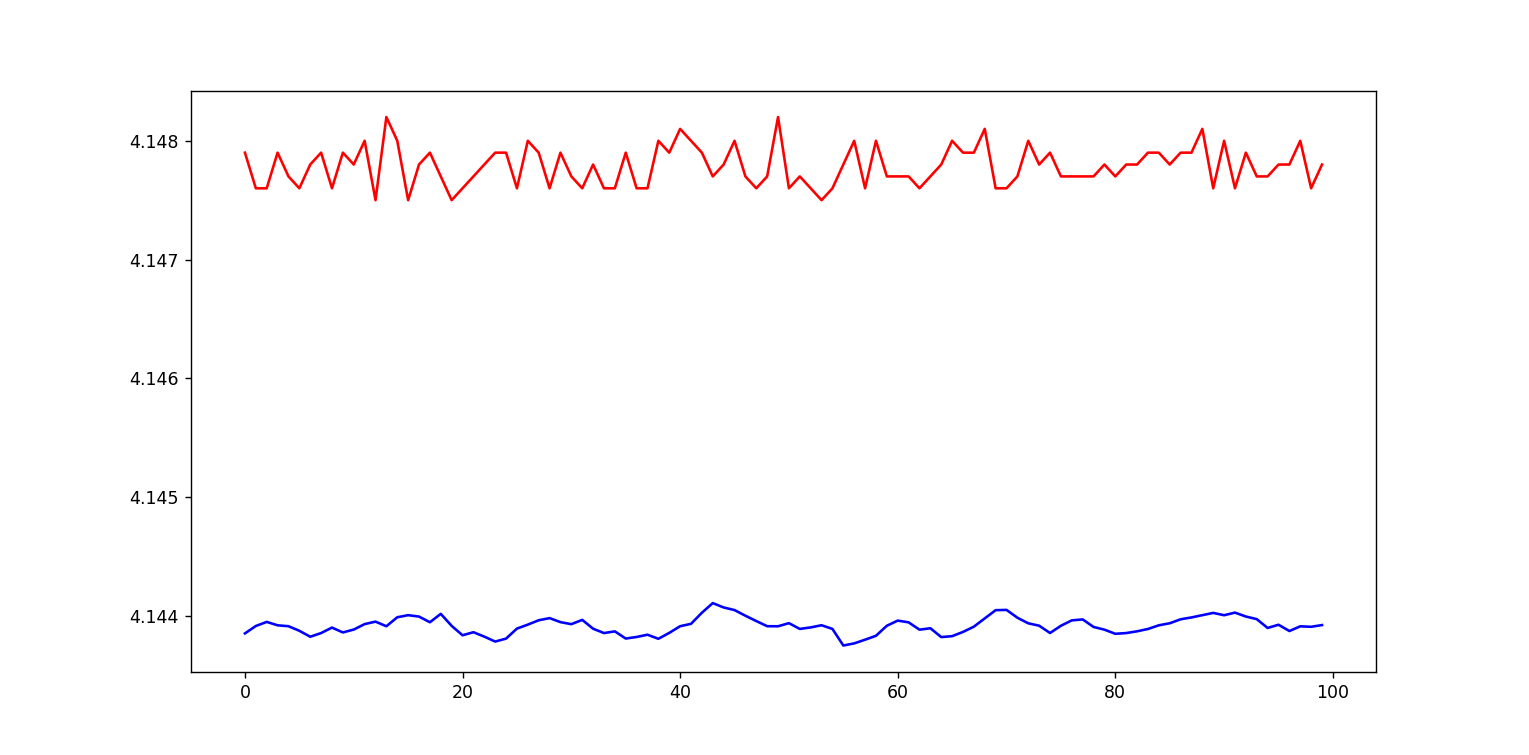

In [68]:
%matplotlib notebook
plt.plot(val_results['Val Predictions'][:100], 'b', label='Validation Predictions')
plt.plot(val_results['Actuals'][:100], 'r', label='Validation Actuals')

In [69]:
# test data was never seen by model
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

,Test Predictions,Actuals
0,4.123289,4.1254
1,4.123293,4.1256
2,4.123262,4.1261
3,4.123292,4.1259
4,4.123216,4.1260
...,...,...
5613,4.083111,4.0836
5614,4.083121,4.0836
5615,4.083139,4.0836
5616,4.083160,4.0837


<IPython.core.display.Javascript object>


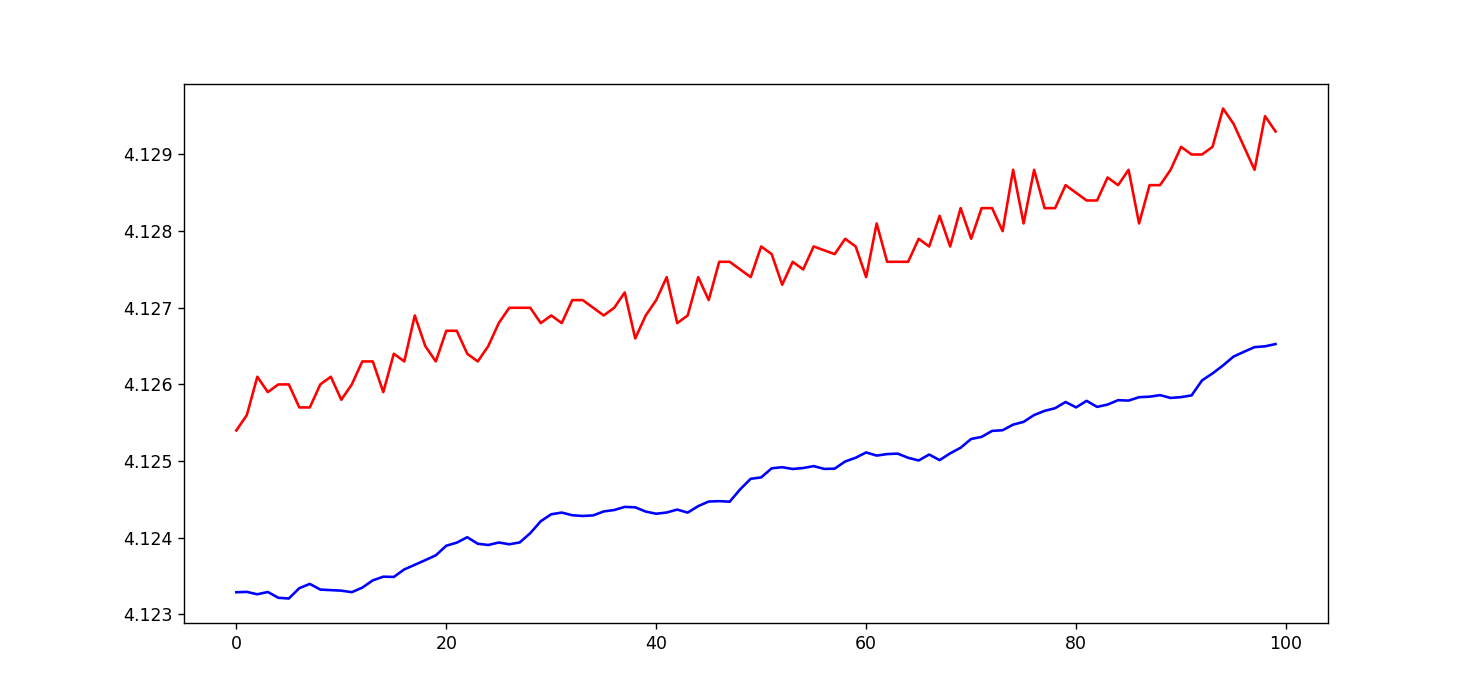

In [70]:
%matplotlib notebook
plt.plot(test_results['Test Predictions'][:100], 'b', label='Test Predictions')
plt.plot(test_results['Actuals'][:100], 'r', label='Test Actual')

### Multivariate: Use current, voltage, temperature (more variables can be added later)

Using time as variable: only relevant when seasonal properties/periodicity can be relevant

### Pre-processing: 
**Normalization vs Standardization**:
1. Normalization (MinMaxScalar) makes values between 0 and 1. If the maximum value is an outliar, it is not a good idea to use min max scalar becasue if the distribution is shrinked too narrow, min max scaling might affect the algorithm to treat outliars as more important 
2. Standardization makes mean=0 and standard deviation=1. If there are outliars, it is preserved in standardization ie it is still an outlier after processing

**Sparse data:**
This is when a lot of data in the dataset are meaningless/not significant i.e. zero (0) values. Centering sparse data i.e. using standard scaling would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales. If sparse data is present, then $with_mean=False$ can be used. Howver, for our data, sparsity does not exist so no need to worry about it.


In [19]:

cols = list(df_connected_V1)[1:4]    # column variables that are necessary for algo: voltage, current, mean temp
df_multivar_train = df_connected_V1[cols].astype(float)

print(df_multivar_train.head(5))
scaler = StandardScaler().fit(df_multivar_train)    # just fit, not transform yet
print(scaler)        # StandardScaler()

print('mean before standardization', scaler.mean_)     # mean
print('variance before standardization', scaler.scale_)    # variance

df_multivar_train_scaled = scaler.transform(df_multivar_train)

print('\nmean after standard scaling', df_multivar_train_scaled.mean(axis=0))     # mean, almost zero
print('standard deviation after standard scaling', df_multivar_train_scaled.std(axis=0))    # variance

# print(df_multivar_train_scaled[:20])   # This is a numpy array

# Make multivariate dataset ready for LSTM
# [temporal input sequence] [output]


# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def preprocess_time_sereis(df_as_np, input_window, output_window=1):
    X = []
    y = []
    for i in range(len(df_as_np) - input_window):
        X.append(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
#         print(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
        label = df_as_np[i+input_window][0]    # 0th index is voltage
        y.append(label)
    
    return np.array(X), np.array(y)

            V1  current  Temp_mean_module1
1096325  4.143      0.0               12.0
1096326  4.140      0.0               13.0
965787   4.140      0.0               13.0
965788   4.140      0.0               13.0
965789   4.140      0.0               13.0
StandardScaler()
mean before standardization [ 4.03478169 -3.00517905  9.57879915]
variance before standardization [ 0.11169335 27.3047484   2.1057379 ]

mean after standard scaling [ 2.68277385e-15 -4.00926921e-18 -2.86949125e-16]
standard deviation after standard scaling [1. 1. 1.]


In [20]:
output_window = 1    # how many values to predict/output label
input_window = 10    # map past 10 second values to the current output

print(df_multivar_train_scaled.shape)

X1, y1 = preprocess_time_sereis(df_multivar_train_scaled, input_window, output_window)
print(X1.shape, y1.shape)
# print(X1[1000:1005], y1[1000:1005])  # test

(49623, 3)
(49613, 10, 3) (49613,)


In [21]:
import math

# Train-validation-test split (60-20-20)
total_data_points = y1.shape[0]
train_total = math.floor(total_data_points * 0.6)
remaining = total_data_points - train_total
val_total = math.floor(remaining * 0.5)

X_train, y_train = X1[:train_total], y1[:train_total]
X_val, y_val = X1[train_total:train_total+val_total], y1[train_total:train_total+val_total]
X_test, y_test = X1[train_total+val_total:], y1[train_total+val_total:]
print(X_train.shape,y_train.shape)

(29767, 10, 3) (29767,)


In [24]:
print(X_train[0])
print(X_train[1])


[[0.96888774 0.11006068 1.14981112]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94292379 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]]
[[0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94292379 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]
 [0.94202849 0.11006068 1.62470403]]


In [ ]:
print(X_train[0])


In [130]:
# Build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# The architecture of the model has to be optimized later
model_LSTM_mutivariate = Sequential()
model_LSTM_mutivariate.add(InputLayer((X_train.shape[1], X_train.shape[2])))   # input_window, #input_variables
model_LSTM_mutivariate.add(LSTM(64))
model_LSTM_mutivariate.add(Dense(8, 'relu'))      # relu: make negative inputs zero, good for backpropagation and gradient-based methods
model_LSTM_mutivariate.add(Dense(1, 'linear'))    # output layer

model_LSTM_mutivariate.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                17408     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________


In [131]:
# model_LSTM_mutivariate
cp_LSTM_mutivariate = ModelCheckpoint('model_LSTM_mutivariate/', save_best_only=True)         # save_best_only=true saves the best model with lowest validation loss
model_LSTM_mutivariate.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Adam optimizer is better than classical stochastic gradient descent to update network weights iterative based in training data
# The loss function is used to optimize model. Here, MeanSquaredError function will get minimized by Adam optimizer
# Metric is used to judge the performance of model. This is only to look at and has nothing to do with the optimization process.

In [132]:
# measuers performance on every epoch on the validation dataset
# calls back checkpoint after every epoch and saves model if validation loss is lower than before

# stop if val_loss not improve in 2 iterations
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

history = model_LSTM_mutivariate.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp_LSTM_mutivariate])

# The batch size is a number of samples processed before the model is updated.
# The number of epochs is the number of complete passes through the training dataset.

Epoch 1/10
922/931 [============================>.] - ETA: 0s - loss: 0.1222 - root_mean_squared_error: 0.3495

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.1212 - root_mean_squared_error: 0.3481 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1513
Epoch 2/10
915/931 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1033

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 3/10
917/931 [============================>.] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0903

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 4/10
927/931 [============================>.] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0845

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 5/10
926/931 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0802

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 6/10
917/931 [============================>.] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0773

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 7/10
925/931 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0755

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 8/10
919/931 [============================>.] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0745

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 9/10
930/931 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0732

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 10/10
923/931 [============================>.] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0725

INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


INFO:tensorflow:Assets written to: model_LSTM_mutivariate\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866


<IPython.core.display.Javascript object>


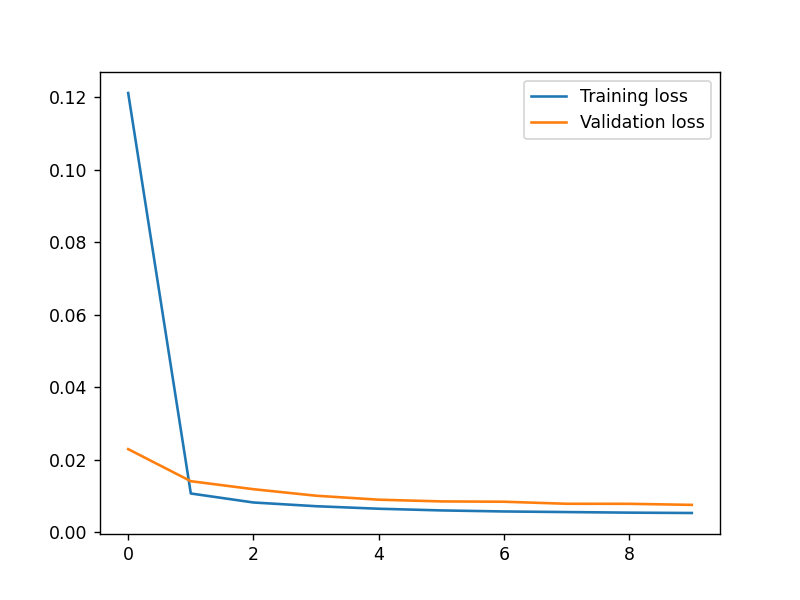

In [134]:
%matplotlib notebook
# plot train and val losss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [26]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model_LSTM_mutivariate = load_model('model_LSTM_mutivariate/')

In [27]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of data points
    
    # Perform inverse transformation to rescale back to original range
    # Since we used 3 variables for transform, the inverse expects same dimensions
    # Therefore, copy same values 3 times and discard them after inverse transform
    prediction_copies = np.repeat(predictions, X.shape[2], axis=1)   # X.shape[2] is number of variables
    y_pred = scaler.inverse_transform(prediction_copies)[:,0]

    # print(y.shape)   # shape is (n,) e.g. 1D array
    y_actual = np.reshape(y, (y.shape[0], 1))    # make it 2D
    print(y_actual.shape)
    # reverse transform for actuals
    actual_copies = np.repeat(y_actual, X.shape[2], axis=1)   # X.shape[2] is number of variables
    y_actual = scaler.inverse_transform(actual_copies)[:,0]

    df = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_actual})
    df_temp = pd.DataFrame()
    df_temp['counter'] = range(len(y))   # x axis for plot
    custom_plot.plot_dual_axis((df_temp['counter'], "Time"), (df['Predictions'][start:end], "Predicted voltage"), (df['Actuals'], "Actual voltage"))
    print("MSE: ", mse(y, predictions))
    print("RMSE: ", mse(y, predictions, squared=False))
    print("MAE: ", mae(y, predictions))
    print("MAPE: ", mape(y, predictions))

(29767, 1)


<IPython.core.display.Javascript object>


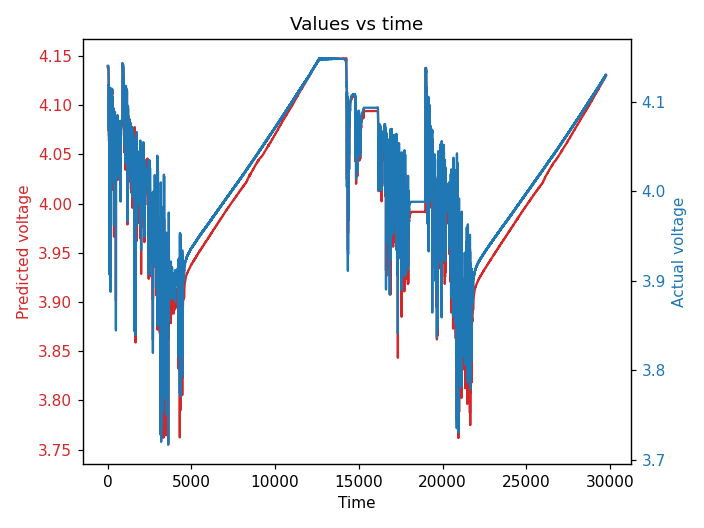

MSE:  0.005550639592784773
RMSE:  0.07450261467079376
MAE:  0.02807998622449949
MAPE:  0.16605621088365238
(9923, 1)


<IPython.core.display.Javascript object>


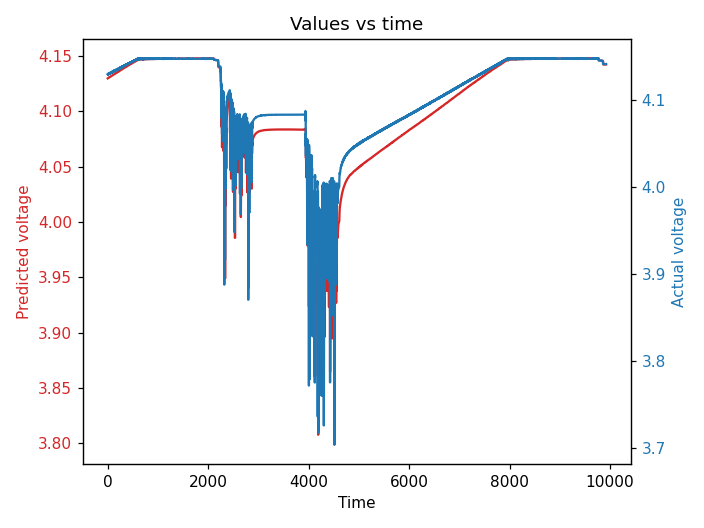

MSE:  0.0075079952002051285
RMSE:  0.08664868839287257
MAE:  0.018814740711785086
MAPE:  0.09230236292437387
(9923, 1)


<IPython.core.display.Javascript object>


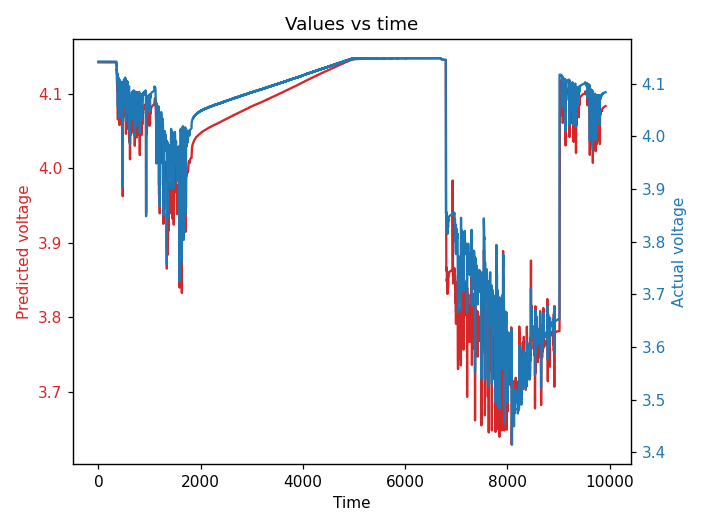

MSE:  0.27355820950535215
RMSE:  0.5230279242118456
MAE:  0.23272411277359303
MAPE:  0.38473911764893476


In [28]:
%matplotlib notebook

# scale 
plot_predictions1(model_LSTM_mutivariate, X_train, y_train, start=0, end=y_train.shape[0])  # prediction on training data
plot_predictions1(model_LSTM_mutivariate, X_val, y_val, start=0, end=y_train.shape[0])  # prediction on val data
plot_predictions1(model_LSTM_mutivariate, X_test, y_test, start=0, end=y_train.shape[0])  # prediction on test data

In [58]:
# Forecasting
# Apply rolling to foerrecast, the idea here: https://tsfresh.readthedocs.io/en/latest/text/forecasting.html
# Take a single data point and predict for that point, replace next actual data point with the predicted value, and move forward

# As prediction has to be done for each element, take the first data point
# np_input[0].reshape(np_input, (np_input[0].shape[0], 1))

def get_forecast_list(np_input, num_forecast, freeze=False):
    NUM_INPUT_VARS = np_input.shape[2]
    FREEZE_DURATION = 15*60    # how many seconds we want to freeze (ex 15 minutes)
    np_input_copy = np.empty((num_forecast, input_window, NUM_INPUT_VARS), float)

    for i in range(num_forecast):
        np_input_copy[i] = np_input[i]      # fill with actual values

    li_predicted = []
    # predict and append
    for i in range(num_forecast):
        pred_ID = i + input_window    # nth prediction
        # single_input empty array is necessary because LSTM prediction takes input in (num_datapoints, input_window, num_variables) format 
        single_input = np.empty((1, input_window, NUM_INPUT_VARS), float)

        # whereas np_input[0] is in (input_window, num_variables) format
        single_input[0] = np_input[i]
    #     single_input_last_index = single_input.shape[1] - 1      # index where voltage needs to be replaced with predictions
    #     print('single_input_last_index: ', single_input_last_index)
        if(len(li_predicted) > 0):
            # print('li_predicted: ', li_predicted)
            for j in range(1, len(li_predicted)+1):
                if(j <= input_window):           # max 10 values to replace as window size is 10
                    _, single_input[0][-j][0] = li_predicted[-j]  # replace from last to first

        predictions = model_LSTM_mutivariate.predict(single_input).flatten()    # flatten returns 1D array
        li_predicted.append((pred_ID, predictions[0]))   # tuple of (id, predicted_value)

    li_rolling_predictoins = []
    for time_id,predict_val in li_predicted:
        li_rolling_predictoins.append(predict_val)        

    # Current freezing
    if(freeze):
        # num_input_samples = np_input.shape[0]
        freeze_start_index = num_forecast - FREEZE_DURATION
        for i in range(freeze_start_index, num_forecast):
            for j in range(input_window):
                np_input_copy[i][j][1] = 0       # asisgn current = 0
        return np_input_copy, li_rolling_predictoins
    else:
        return li_rolling_predictoins


In [38]:
# print(list_predicted)
li_train_forecast = get_forecast_list(X_train, 900)           # 15 minute forecast
np_train_forecast = np.array(li_train_forecast)

li_val_forecast = get_forecast_list(X_val, 900)
np_val_forecast = np.array(li_val_forecast)

li_test_forecast = get_forecast_list(X_test, 900)
np_test_forecast = np.array(li_test_forecast)

(900, 1)


<IPython.core.display.Javascript object>


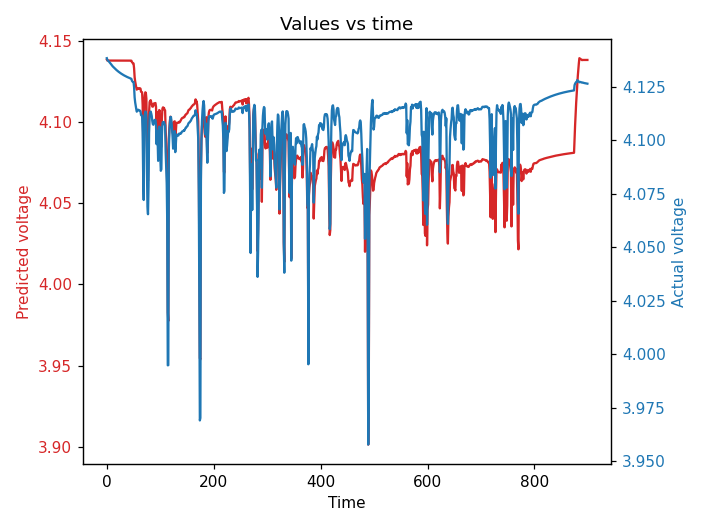

MSE:  0.06829942
RMSE:  0.26134157
MAE:  0.21990183
MAPE:  0.37917358
(900, 1)


<IPython.core.display.Javascript object>


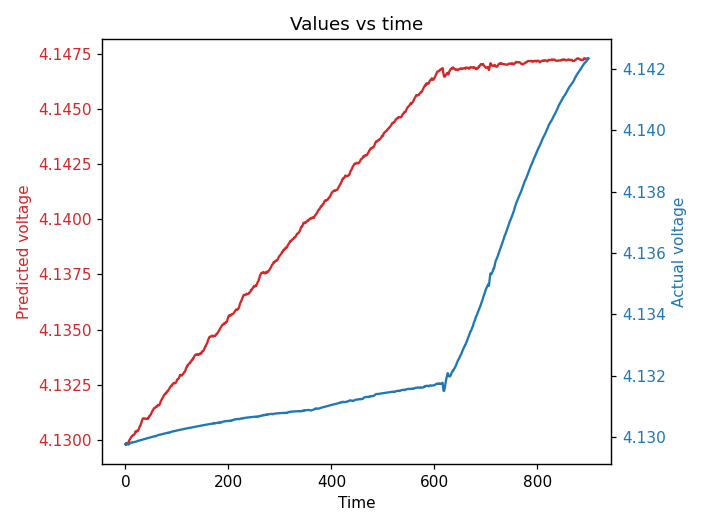

MSE:  0.006988317
RMSE:  0.083596155
MAE:  0.07475703
MAPE:  0.08510988
(900, 1)


<IPython.core.display.Javascript object>


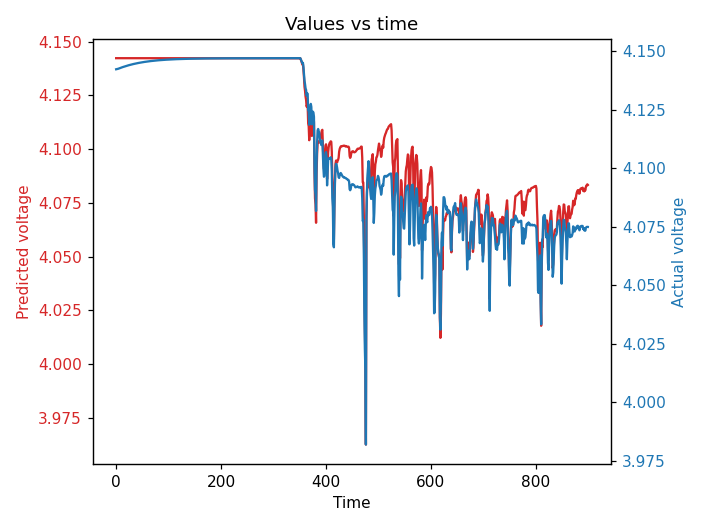

MSE:  0.0038067787
RMSE:  0.0616991
MAE:  0.052464508
MAPE:  0.1444296


In [40]:
%matplotlib notebook

# Example: take first 900 values
plot_predictions1(model_LSTM_mutivariate, X_train[:900], np_train_forecast, start=0, end=y_train.shape[0])  # rolling forecast on training data
plot_predictions1(model_LSTM_mutivariate, X_val[:900], np_val_forecast, start=0, end=y_train.shape[0])  # rolling forecast on val data
plot_predictions1(model_LSTM_mutivariate, X_test[:900], np_test_forecast, start=0, end=y_train.shape[0])  # rolling forecast on test data

In [59]:
# Test current freezing
forecast_sec = 2*3600
np_frozen_input, li_forecast_freeze = get_forecast_list(X_test, forecast_sec, True)           # 2 hour forecast
np_test_forecast_freeze = np.array(li_forecast_freeze)

(7200, 1)


<IPython.core.display.Javascript object>


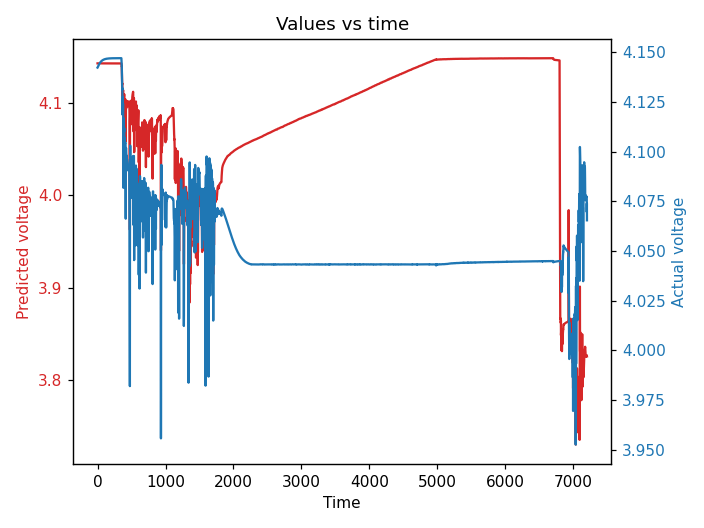

MSE:  0.61308336
RMSE:  0.7829964
MAE:  0.6287564
MAPE:  8.592644


In [60]:
%matplotlib notebook

# test forecast with input freezing
plot_predictions1(model_LSTM_mutivariate, np_frozen_input[:forecast_sec], np_test_forecast_freeze, start=0, end=forecast_sec)  # rolling forecast on test data

## predict with 1D convolution

In [187]:
model_conv = Sequential()
model_conv.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model_conv.add(Conv1D(64, kernel_size=2))
model_conv.add(Flatten())
model_conv.add(Dense(8, 'relu'))
model_conv.add(Dense(1, 'linear'))

model_conv.summary()

cp_conv = ModelCheckpoint('model_conv/', save_best_only=True)
model_conv.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 9, 64)             448       
                                                                 
 flatten_5 (Flatten)         (None, 576)               0         
                                                                 
 dense_20 (Dense)            (None, 8)                 4616      
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,073
Trainable params: 5,073
Non-trainable params: 0
_________________________________________________________________


In [188]:
history_conv = model_conv.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp_conv])

Epoch 1/20
872/931 [===========================>..] - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.2340INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 2s 2ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 2/20
914/931 [============================>.] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0914INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 3/20
923/931 [============================>.] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0809INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0919
Epoch 4/20
899/931 [===========================>..] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0821INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 5/20
880/931 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0771INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 2ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 6/20
911/931 [============================>.] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0822INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 7/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 8/20
928/931 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0758INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 9/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0863
Epoch 10/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 11/20
894/931 [===========================>..] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0782INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 12/20
883/931 [===========================>..] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0774INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 13/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 14/20
931/931 [==============================] - 1s 984us/step - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 15/20
919/931 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0759INFO:tensorflow:Assets written to: model_conv\assets


INFO:tensorflow:Assets written to: model_conv\assets


931/931 [==============================] - 1s 1ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841
Epoch 16/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0752 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 17/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 18/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 19/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 20/20
931/931 [==============================] - 1s 1ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0074 - val_root_m

<IPython.core.display.Javascript object>


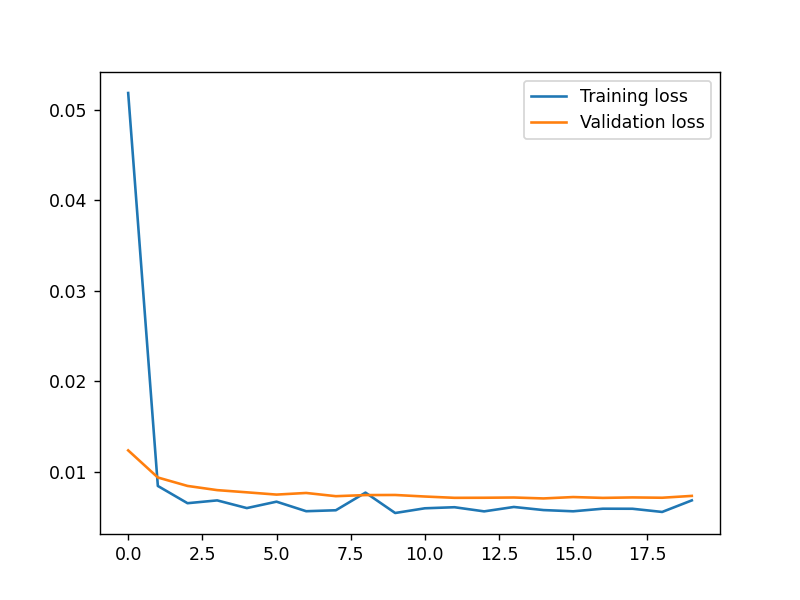

In [189]:
%matplotlib notebook
# plot train and val losss
plt.plot(history_conv.history['loss'], label='Training loss')
plt.plot(history_conv.history['val_loss'], label='Validation loss')
plt.legend()

In [190]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model_conv = load_model('model_conv/')

(29767, 1)


<IPython.core.display.Javascript object>


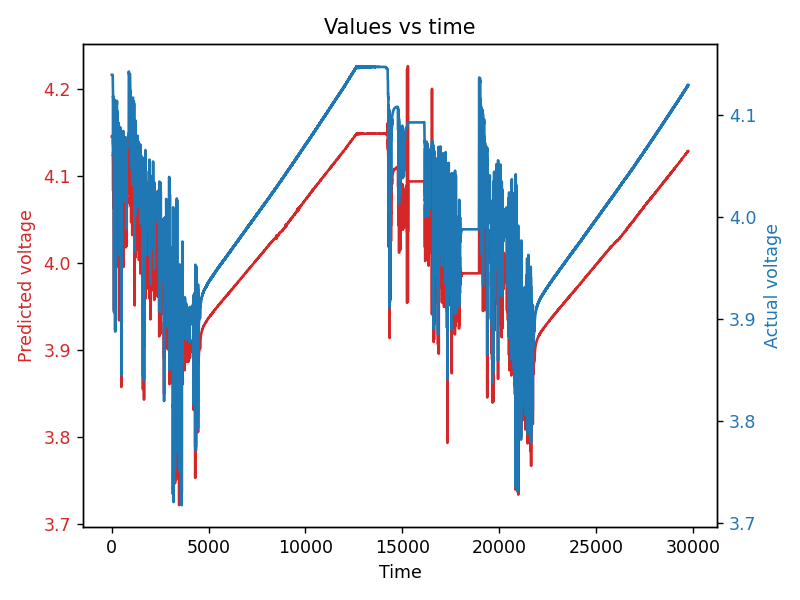

Mean squared error:  0.005293418688104565
(9923, 1)


<IPython.core.display.Javascript object>


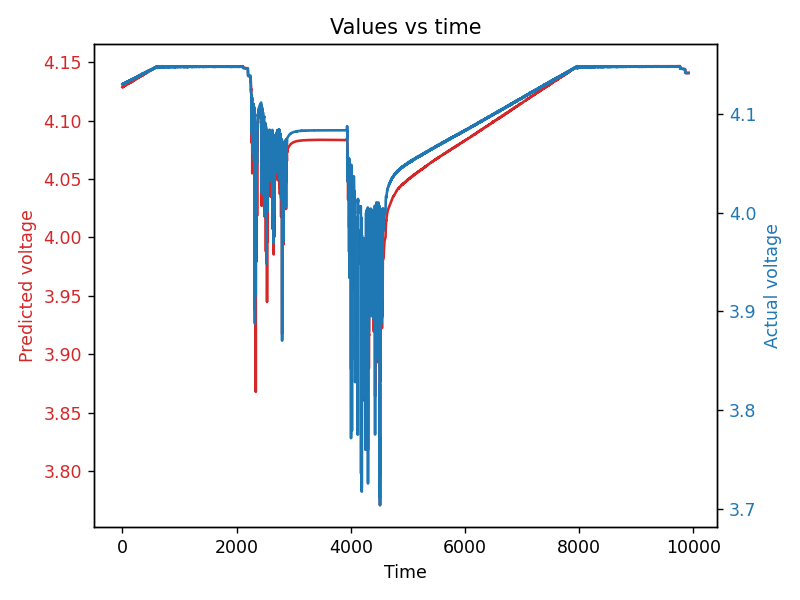

Mean squared error:  0.007070513882651092
(9923, 1)


<IPython.core.display.Javascript object>


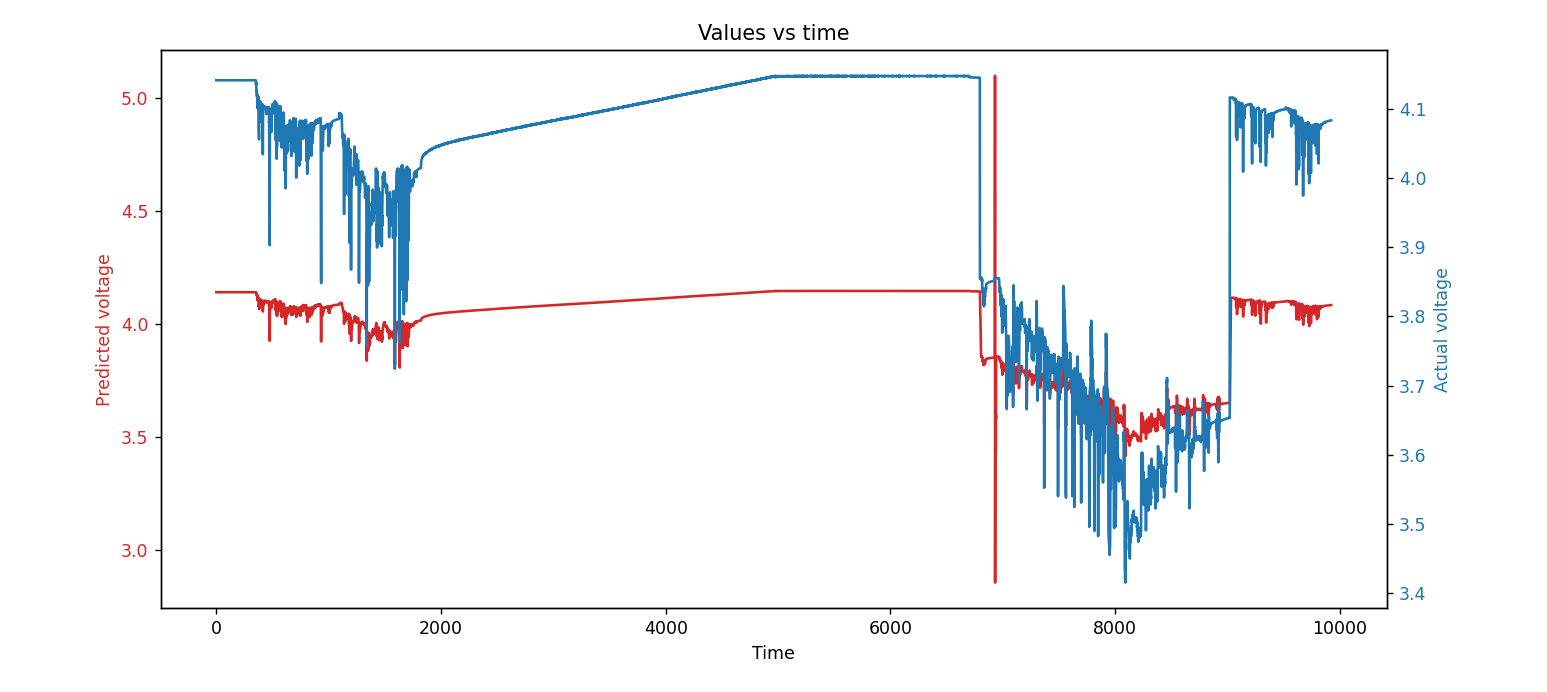

Mean squared error:  0.04589616182537113


In [191]:
%matplotlib notebook

# scale 
plot_predictions1(model_conv, X_train, y_train, start=0, end=y_train.shape[0])  # prediction on training data
plot_predictions1(model_conv, X_val, y_val, start=0, end=y_train.shape[0])  # prediction on val data
plot_predictions1(model_conv, X_test, y_test, start=0, end=y_train.shape[0])  # prediction on test data

## GRU model

In [192]:
model_GRU = Sequential()
model_GRU.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model_GRU.add(GRU(64))
model_GRU.add(Dense(8, 'relu'))
model_GRU.add(Dense(1, 'linear'))
model_GRU.summary()

cp_GRU = ModelCheckpoint('model_GRU/', save_best_only=True)
model_GRU.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13248     
                                                                 
 dense_22 (Dense)            (None, 8)                 520       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,777
Trainable params: 13,777
Non-trainable params: 0
_________________________________________________________________


In [193]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp_GRU])

Epoch 1/10
920/931 [============================>.] - ETA: 0s - loss: 0.0862 - root_mean_squared_error: 0.2936

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 7s 6ms/step - loss: 0.0853 - root_mean_squared_error: 0.2921 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 2/10
926/931 [============================>.] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0808

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0914
Epoch 3/10
931/931 [==============================] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0753

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 4/10
925/931 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0736

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 5/10
919/931 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0724

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 6ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 6/10
931/931 [==============================] - 4s 4ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 7/10
918/931 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0710

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 8/10
925/931 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0708

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 9/10
915/931 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0705

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 5s 5ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 10/10
925/931 [============================>.] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0702

INFO:tensorflow:Assets written to: model_GRU\assets


INFO:tensorflow:Assets written to: model_GRU\assets


931/931 [==============================] - 6s 6ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838


<IPython.core.display.Javascript object>


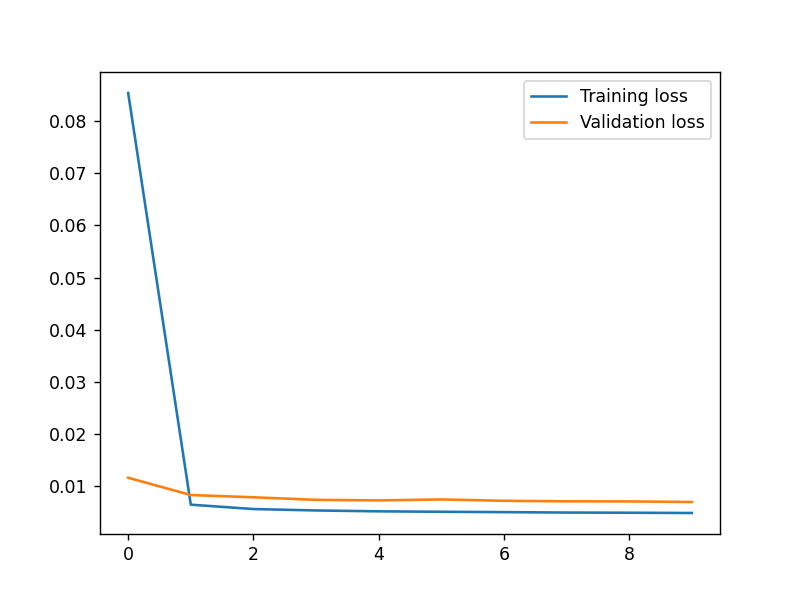

In [194]:
%matplotlib notebook
# plot train and val losss
plt.plot(history_GRU.history['loss'], label='Training loss')
plt.plot(history_GRU.history['val_loss'], label='Validation loss')
plt.legend()

In [196]:
# load model with lowest validation loss
from tensorflow.keras.models import load_model
model_GRU = load_model('model_GRU/')

(29767, 1)


<IPython.core.display.Javascript object>


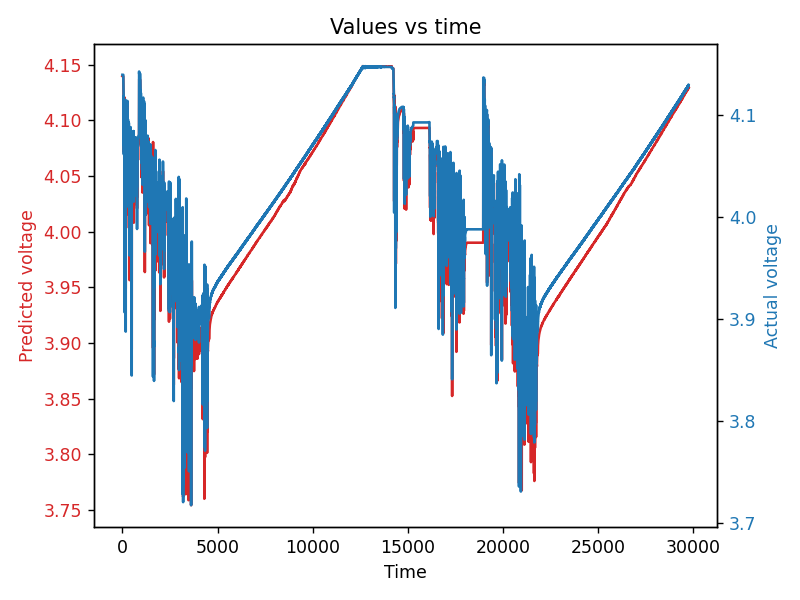

Mean squared error:  0.004961927294454731
(9923, 1)


<IPython.core.display.Javascript object>


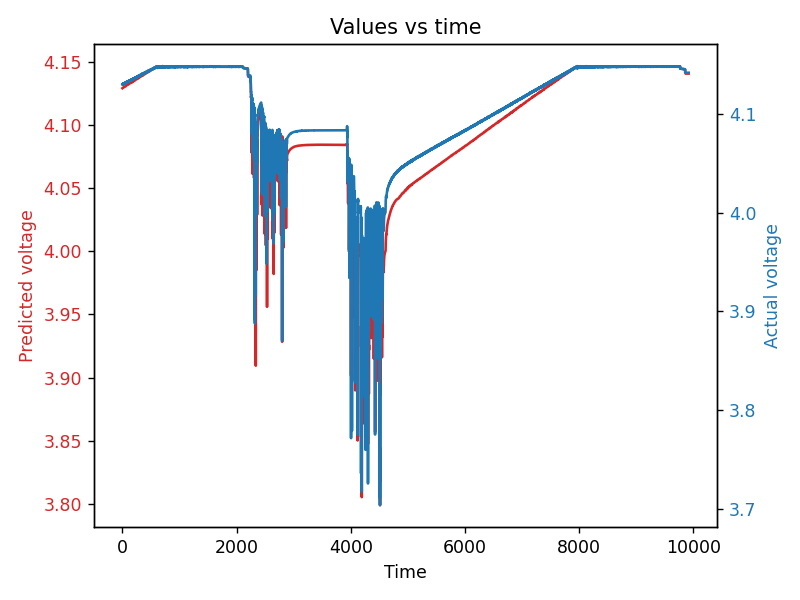

Mean squared error:  0.0070223856760246815
(9923, 1)


<IPython.core.display.Javascript object>


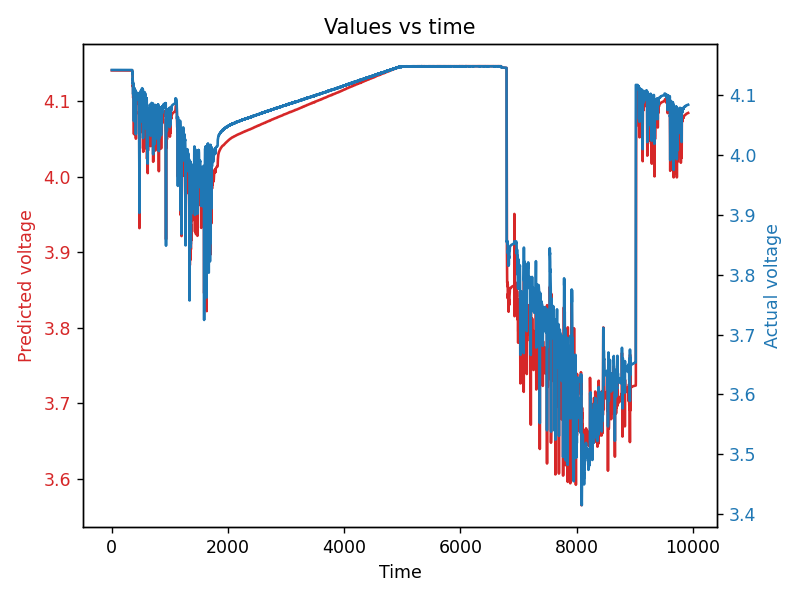

Mean squared error:  0.1267739471022983


In [197]:
%matplotlib notebook

# scale 
plot_predictions1(model_GRU, X_train, y_train, start=0, end=y_train.shape[0])  # prediction on training data
plot_predictions1(model_GRU, X_val, y_val, start=0, end=y_train.shape[0])  # prediction on val data
plot_predictions1(model_GRU, X_test, y_test, start=0, end=y_train.shape[0])  # prediction on test data

## LSTM with 

In [ ]:
model6 = Sequential()
model6.add(InputLayer((7, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

model6.summary()

In [ ]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model6.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp6])

In [ ]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

cp7 = ModelCheckpoint('model6/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model7.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp7])